In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from tqdm import tqdm


In [ ]:
class SmallCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SmallCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 16x16

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 8x8

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),  # 1x1
        )
        self.classifier = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        return self.classifier(x)


In [ ]:
device='cuda'
# Student model
student = SmallCNN(num_classes=10).to(device)

# Teacher model: ResNet101 with CIFAR-10-compatible classifier
teacher = models.resnet101(num_classes=10)  # Using ResNet-101
teacher.fc = nn.Linear(teacher.fc.in_features, 10)
teacher = teacher.to(device)



In [ ]:
# Data transforms
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# CIFAR-10 datasets
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)


In [ ]:
def train_model(model, train_loader, test_loader, epochs=20, lr=0.1):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0

        for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

        acc = 100. * correct / total
        print(f"Train Loss: {running_loss/len(train_loader):.4f} | Train Acc: {acc:.2f}%")

        test_accuracy(model, test_loader)
        scheduler.step()

def test_accuracy(model, dataloader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    acc = 100. * correct / total
    print(f"Test Accuracy: {acc:.2f}%\n")


In [ ]:
# Train teacher
train_model(teacher, train_loader, test_loader, epochs=10, lr=0.01)


Epoch 1/5: 100%|██████████| 391/391 [00:45<00:00,  8.53it/s]

Train Loss: 0.5638 | Train Acc: 80.31%


Test Accuracy: 79.47%



Epoch 2/5: 100%|██████████| 391/391 [00:45<00:00,  8.64it/s]

Train Loss: 0.5525 | Train Acc: 80.81%


Test Accuracy: 79.15%



Epoch 3/5: 100%|██████████| 391/391 [00:45<00:00,  8.66it/s]

Train Loss: 0.5455 | Train Acc: 80.71%


Test Accuracy: 77.94%



Epoch 4/5: 100%|██████████| 391/391 [00:45<00:00,  8.61it/s]

Train Loss: 0.5380 | Train Acc: 81.20%


Test Accuracy: 79.05%



Epoch 5/5: 100%|██████████| 391/391 [00:45<00:00,  8.56it/s]

Train Loss: 0.5327 | Train Acc: 81.33%


Test Accuracy: 79.48%



In [ ]:
from torchvision.models import ResNet101_Weights
#teacher 2 config
teacher2 = models.resnet101(weights=ResNet101_Weights.IMAGENET1K_V2)  # Using ResNet-101
teacher2.fc = nn.Linear(teacher2.fc.in_features, 10)
teacher2 = teacher2.to(device)

Downloading: "https://download.pytorch.org/models/resnet101-cd907fc2.pth" to /root/.cache/torch/hub/checkpoints/resnet101-cd907fc2.pth
100%|██████████| 171M/171M [00:01<00:00, 131MB/s]


In [ ]:
#teacher 2 train
train_model(teacher2, train_loader, test_loader, epochs=10, lr=0.01)


Epoch 1/10: 100%|██████████| 391/391 [00:45<00:00,  8.59it/s]

Train Loss: 0.2255 | Train Acc: 92.15%


Test Accuracy: 87.22%



Epoch 2/10: 100%|██████████| 391/391 [00:45<00:00,  8.69it/s]

Train Loss: 0.1880 | Train Acc: 93.58%


Test Accuracy: 87.40%



Epoch 3/10: 100%|██████████| 391/391 [00:45<00:00,  8.62it/s]

Train Loss: 0.1822 | Train Acc: 93.67%


Test Accuracy: 87.15%



Epoch 4/10: 100%|██████████| 391/391 [00:44<00:00,  8.71it/s]

Train Loss: 0.1654 | Train Acc: 94.21%


Test Accuracy: 87.06%



Epoch 5/10: 100%|██████████| 391/391 [00:44<00:00,  8.78it/s]

Train Loss: 0.1647 | Train Acc: 94.26%


Test Accuracy: 86.78%



Epoch 6/10: 100%|██████████| 391/391 [00:44<00:00,  8.75it/s]

Train Loss: 0.1559 | Train Acc: 94.59%


Test Accuracy: 87.17%



Epoch 7/10: 100%|██████████| 391/391 [00:44<00:00,  8.69it/s]

Train Loss: 0.1393 | Train Acc: 95.12%


Test Accuracy: 87.39%



Epoch 8/10: 100%|██████████| 391/391 [00:45<00:00,  8.64it/s]

Train Loss: 0.1327 | Train Acc: 95.48%


Test Accuracy: 86.73%



Epoch 9/10: 100%|██████████| 391/391 [00:45<00:00,  8.57it/s]

Train Loss: 0.1283 | Train Acc: 95.57%


Test Accuracy: 87.32%



Epoch 10/10: 100%|██████████| 391/391 [00:45<00:00,  8.54it/s]

Train Loss: 0.1236 | Train Acc: 95.70%


Test Accuracy: 87.54%



In [ ]:
def distillation_loss(student_outputs, teacher_outputs, targets, T=2.0, alpha=0.5):
    # Soft target loss (KL Divergence)
    soft_loss = F.kl_div(F.log_softmax(student_outputs / T, dim=1),
                         F.softmax(teacher_outputs / T, dim=1),
                         reduction='batchmean') * (T * T)

    # Hard target loss (Cross Entropy)
    hard_loss = F.cross_entropy(student_outputs, targets)

    # Combined loss: weighted sum of soft and hard losses
    return alpha * soft_loss + (1. - alpha) * hard_loss


In [ ]:
def train_student(student, teacher, train_loader, epochs=20, lr=0.1, T=2.0, alpha=0.5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(student.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    teacher.eval()  # Keep the teacher model in evaluation mode (no gradients)

    for epoch in range(epochs):
        student.train()
        running_loss = 0.0
        correct, total = 0, 0

        for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()

            # Forward pass: Student gets the inputs, teacher gets the same
            student_outputs = student(inputs)
            teacher_outputs = teacher(inputs)

            # Compute the distillation loss
            loss = distillation_loss(student_outputs, teacher_outputs, targets, T, alpha)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = student_outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

        acc = 100. * correct / total
        print(f"Train Loss: {running_loss/len(train_loader):.4f} | Train Acc: {acc:.2f}%")

        test_accuracy(student, test_loader)  # Evaluate student on test set
        scheduler.step()


In [ ]:
# Train the student model using knowledge distillation
train_student(student, teacher, train_loader, epochs=20, lr=0.05, T=2.0, alpha=0.5)


Epoch 1/20: 100%|██████████| 391/391 [00:44<00:00,  8.78it/s]

Train Loss: 2.4126 | Train Acc: 30.03%


Test Accuracy: 39.87%



Epoch 2/20: 100%|██████████| 391/391 [00:43<00:00,  8.99it/s]

Train Loss: 1.7068 | Train Acc: 47.38%


Test Accuracy: 52.83%



Epoch 3/20: 100%|██████████| 391/391 [00:43<00:00,  8.96it/s]

Train Loss: 1.4048 | Train Acc: 55.18%


Test Accuracy: 52.06%



Epoch 4/20: 100%|██████████| 391/391 [00:43<00:00,  9.02it/s]

Train Loss: 1.2232 | Train Acc: 60.00%


Test Accuracy: 62.71%



Epoch 5/20: 100%|██████████| 391/391 [00:42<00:00,  9.10it/s]

Train Loss: 1.1196 | Train Acc: 62.98%


Test Accuracy: 63.24%



Epoch 6/20: 100%|██████████| 391/391 [00:43<00:00,  9.02it/s]

Train Loss: 1.0117 | Train Acc: 65.93%


Test Accuracy: 66.67%



Epoch 7/20: 100%|██████████| 391/391 [00:43<00:00,  8.98it/s]

Train Loss: 0.9461 | Train Acc: 67.76%


Test Accuracy: 67.00%



Epoch 8/20: 100%|██████████| 391/391 [00:43<00:00,  9.05it/s]

Train Loss: 0.8960 | Train Acc: 69.34%


Test Accuracy: 71.13%



Epoch 9/20: 100%|██████████| 391/391 [00:43<00:00,  9.00it/s]

Train Loss: 0.8549 | Train Acc: 70.57%


Test Accuracy: 71.62%



Epoch 10/20: 100%|██████████| 391/391 [00:42<00:00,  9.10it/s]

Train Loss: 0.8070 | Train Acc: 71.92%


Test Accuracy: 71.90%



Epoch 11/20: 100%|██████████| 391/391 [00:43<00:00,  9.04it/s]

Train Loss: 0.6796 | Train Acc: 75.05%


Test Accuracy: 74.63%



Epoch 12/20: 100%|██████████| 391/391 [00:42<00:00,  9.10it/s]

Train Loss: 0.6698 | Train Acc: 75.53%


Test Accuracy: 75.14%



Epoch 13/20: 100%|██████████| 391/391 [00:42<00:00,  9.11it/s]

Train Loss: 0.6591 | Train Acc: 76.02%


Test Accuracy: 75.02%



Epoch 14/20: 100%|██████████| 391/391 [00:43<00:00,  9.01it/s]

Train Loss: 0.6538 | Train Acc: 76.21%


Test Accuracy: 75.48%



Epoch 15/20: 100%|██████████| 391/391 [00:43<00:00,  9.09it/s]

Train Loss: 0.6485 | Train Acc: 76.51%


Test Accuracy: 75.18%



Epoch 16/20: 100%|██████████| 391/391 [00:44<00:00,  8.78it/s]

Train Loss: 0.6445 | Train Acc: 76.56%


Test Accuracy: 75.44%



Epoch 17/20: 100%|██████████| 391/391 [00:43<00:00,  9.03it/s]

Train Loss: 0.6434 | Train Acc: 76.46%


Test Accuracy: 75.85%



Epoch 18/20: 100%|██████████| 391/391 [00:43<00:00,  8.89it/s]

Train Loss: 0.6360 | Train Acc: 76.90%


Test Accuracy: 75.36%



Epoch 19/20: 100%|██████████| 391/391 [00:43<00:00,  8.95it/s]

Train Loss: 0.6358 | Train Acc: 76.68%


Test Accuracy: 75.13%



Epoch 20/20: 100%|██████████| 391/391 [00:43<00:00,  8.99it/s]

Train Loss: 0.6340 | Train Acc: 76.89%


Test Accuracy: 75.98%



In [ ]:
student2 = SmallCNN(num_classes=10).to(device)

In [ ]:
train_student(student2, teacher2, train_loader, epochs=20, lr=0.05, T=2.0, alpha=0.5)


Epoch 1/20: 100%|██████████| 391/391 [00:43<00:00,  8.97it/s]

Train Loss: 1.4136 | Train Acc: 73.72%


Test Accuracy: 71.43%



Epoch 2/20: 100%|██████████| 391/391 [00:43<00:00,  8.91it/s]

Train Loss: 1.3913 | Train Acc: 74.31%


Test Accuracy: 74.90%



Epoch 3/20: 100%|██████████| 391/391 [00:43<00:00,  8.97it/s]

Train Loss: 1.3302 | Train Acc: 75.63%


Test Accuracy: 75.08%



Epoch 4/20: 100%|██████████| 391/391 [00:43<00:00,  8.94it/s]

Train Loss: 1.3070 | Train Acc: 75.87%


Test Accuracy: 76.66%



Epoch 5/20: 100%|██████████| 391/391 [00:43<00:00,  8.96it/s]

Train Loss: 1.2852 | Train Acc: 76.41%


Test Accuracy: 73.46%



Epoch 6/20: 100%|██████████| 391/391 [00:43<00:00,  8.90it/s]

Train Loss: 1.2444 | Train Acc: 76.99%


Test Accuracy: 74.03%



Epoch 7/20: 100%|██████████| 391/391 [00:44<00:00,  8.86it/s]

Train Loss: 1.2211 | Train Acc: 77.48%


Test Accuracy: 76.65%



Epoch 8/20: 100%|██████████| 391/391 [00:43<00:00,  8.94it/s]

Train Loss: 1.2008 | Train Acc: 77.98%


Test Accuracy: 76.18%



Epoch 9/20: 100%|██████████| 391/391 [00:43<00:00,  8.93it/s]

Train Loss: 1.2085 | Train Acc: 78.01%


Test Accuracy: 76.57%



Epoch 10/20: 100%|██████████| 391/391 [00:44<00:00,  8.84it/s]

Train Loss: 1.1806 | Train Acc: 78.12%


Test Accuracy: 76.89%



Epoch 11/20: 100%|██████████| 391/391 [00:43<00:00,  8.93it/s]

Train Loss: 0.9782 | Train Acc: 82.19%


Test Accuracy: 80.82%



Epoch 12/20: 100%|██████████| 391/391 [00:43<00:00,  8.99it/s]

Train Loss: 0.9393 | Train Acc: 82.88%


Test Accuracy: 80.99%



Epoch 13/20: 100%|██████████| 391/391 [00:43<00:00,  8.91it/s]

Train Loss: 0.9318 | Train Acc: 82.89%


Test Accuracy: 81.09%



Epoch 14/20: 100%|██████████| 391/391 [00:43<00:00,  8.99it/s]

Train Loss: 0.9240 | Train Acc: 83.28%


Test Accuracy: 81.63%



Epoch 15/20: 100%|██████████| 391/391 [00:43<00:00,  8.89it/s]

Train Loss: 0.9169 | Train Acc: 83.16%


Test Accuracy: 81.07%



Epoch 16/20: 100%|██████████| 391/391 [00:43<00:00,  9.02it/s]

Train Loss: 0.9102 | Train Acc: 83.43%


Test Accuracy: 81.08%



Epoch 17/20: 100%|██████████| 391/391 [00:43<00:00,  9.00it/s]

Train Loss: 0.9017 | Train Acc: 83.42%


Test Accuracy: 81.22%



Epoch 18/20: 100%|██████████| 391/391 [00:43<00:00,  8.90it/s]

Train Loss: 0.9015 | Train Acc: 83.66%


Test Accuracy: 81.31%



Epoch 19/20: 100%|██████████| 391/391 [00:43<00:00,  8.99it/s]

Train Loss: 0.9011 | Train Acc: 83.60%


Test Accuracy: 81.36%



Epoch 20/20: 100%|██████████| 391/391 [00:43<00:00,  8.92it/s]

Train Loss: 0.8977 | Train Acc: 83.66%


Test Accuracy: 81.00%



In [ ]:
import matplotlib.pyplot as plt
import torchvision
import numpy as np

def unnormalize(img_tensor):
    return img_tensor * 0.5 + 0.5


def show_predictions(teacher, student, dataloader, classes, num_images=10):
    teacher.eval()
    student.eval()

    dataiter = iter(dataloader)
    images, labels = next(dataiter)
    images, labels = images[:num_images], labels[:num_images]

    with torch.no_grad():
        teacher_preds = teacher(images.to(device)).argmax(dim=1)
        student_preds = student(images.to(device)).argmax(dim=1)

    # Unnormalize images
    unnorm_images = [unnormalize(img.cpu()) for img in images]
    grid_img = torchvision.utils.make_grid(torch.stack(unnorm_images), nrow=30)
    npimg = grid_img.numpy().transpose((1, 2, 0))

    plt.figure(figsize=(20, 4))  # Wider figure to fit 10 images
    plt.imshow(np.clip(npimg, 0, 1), interpolation='nearest')
    plt.axis('off')

    for i in range(num_images):
        print(f"Image {i+1}: True: {classes[labels[i]]}, "
              f"Teacher: {classes[teacher_preds[i]]}, "
              f"Student: {classes[student_preds[i]]}")

    plt.show()

def show_individual_predictions(teacher, student, dataloader, classes, num_images=5):
    teacher.eval()
    student.eval()

    dataiter = iter(dataloader)
    images, labels = next(dataiter)
    images, labels = images[:num_images], labels[:num_images]

    with torch.no_grad():
        teacher_preds = teacher(images.to(device)).argmax(dim=1)
        student_preds = student(images.to(device)).argmax(dim=1)

    plt.figure(figsize=(num_images * 2.5, 5))
    for i in range(num_images):
        img = unnormalize(images[i].cpu())
        npimg = img.numpy().transpose((1, 2, 0))

        plt.subplot(2, num_images, i + 1)
        plt.imshow(np.clip(npimg, 0, 1), interpolation='nearest')
        plt.title(f"T: {classes[teacher_preds[i]]}", fontsize=10)
        plt.axis('off')

        plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(np.clip(npimg, 0, 1), interpolation='nearest')
        plt.title(f"S: {classes[student_preds[i]]}", fontsize=10)
        plt.axis('off')

    plt.suptitle("Top: Teacher | Bottom: Student", fontsize=14)
    plt.tight_layout()
    plt.show()

def show_crisp_predictions(teacher, student, dataloader, classes, num_images=5):
    teacher.eval()
    student.eval()

    dataiter = iter(dataloader)
    images, labels = next(dataiter)
    images, labels = images[:num_images], labels[:num_images]

    with torch.no_grad():
        teacher_preds = teacher(images.to(device)).argmax(dim=1)
        student_preds = student(images.to(device)).argmax(dim=1)

    plt.figure(figsize=(num_images * 1.6, 2.8))  # Smaller figure

    for i in range(num_images):
        img = unnormalize(images[i].cpu())
        npimg = img.numpy().transpose((1, 2, 0))

        # Teacher prediction
        plt.subplot(2, num_images, i + 1)
        plt.imshow(np.clip(npimg, 0, 1), interpolation='nearest')
        plt.title(f"T: {classes[teacher_preds[i]]}", fontsize=8)
        plt.axis('off')

        # Student prediction
        plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(np.clip(npimg, 0, 1), interpolation='nearest')
        plt.title(f"S: {classes[student_preds[i]]}", fontsize=8)
        plt.axis('off')

    plt.tight_layout()
    plt.suptitle("Teacher (Top) vs Student (Bottom)", fontsize=10, y=1.05)
    plt.show()


Image 1: True: cat, Teacher: cat, Student: cat
Image 2: True: ship, Teacher: ship, Student: ship
Image 3: True: ship, Teacher: ship, Student: ship
Image 4: True: airplane, Teacher: airplane, Student: ship
Image 5: True: frog, Teacher: frog, Student: frog
Image 6: True: frog, Teacher: frog, Student: frog
Image 7: True: automobile, Teacher: automobile, Student: automobile
Image 8: True: frog, Teacher: frog, Student: frog
Image 9: True: cat, Teacher: cat, Student: cat
Image 10: True: automobile, Teacher: truck, Student: truck
Image 11: True: airplane, Teacher: airplane, Student: airplane
Image 12: True: truck, Teacher: truck, Student: truck
Image 13: True: dog, Teacher: cat, Student: dog
Image 14: True: horse, Teacher: horse, Student: horse
Image 15: True: truck, Teacher: truck, Student: truck
Image 16: True: ship, Teacher: ship, Student: ship
Image 17: True: dog, Teacher: dog, Student: dog
Image 18: True: horse, Teacher: horse, Student: horse
Image 19: True: ship, Teacher: ship, Student:

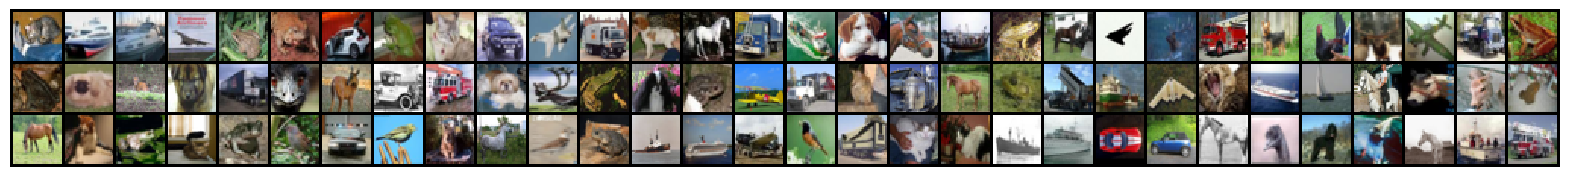

Image 1: True: cat, Teacher: cat, Student: cat
Image 2: True: ship, Teacher: ship, Student: automobile
Image 3: True: ship, Teacher: ship, Student: ship
Image 4: True: airplane, Teacher: airplane, Student: airplane
Image 5: True: frog, Teacher: bird, Student: frog
Image 6: True: frog, Teacher: frog, Student: frog
Image 7: True: automobile, Teacher: automobile, Student: automobile
Image 8: True: frog, Teacher: frog, Student: frog
Image 9: True: cat, Teacher: cat, Student: cat
Image 10: True: automobile, Teacher: automobile, Student: automobile
Image 11: True: airplane, Teacher: airplane, Student: airplane
Image 12: True: truck, Teacher: truck, Student: truck
Image 13: True: dog, Teacher: dog, Student: dog
Image 14: True: horse, Teacher: horse, Student: horse
Image 15: True: truck, Teacher: truck, Student: truck
Image 16: True: ship, Teacher: ship, Student: ship
Image 17: True: dog, Teacher: dog, Student: dog
Image 18: True: horse, Teacher: horse, Student: horse
Image 19: True: ship, Tea

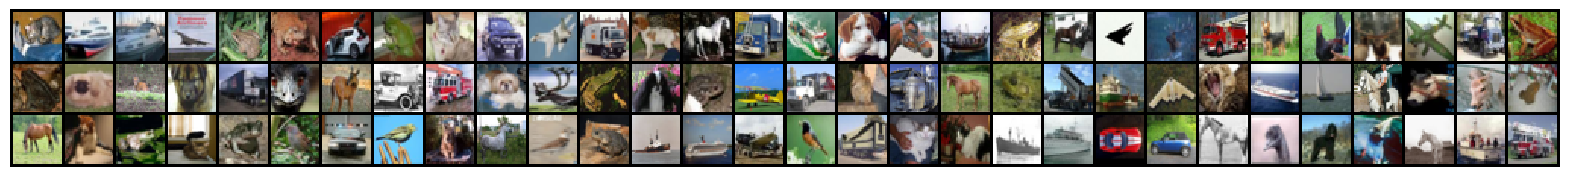

In [ ]:
# Assuming you're using CIFAR-10
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

# Show 5 test samples and predictions
show_predictions(teacher, student, test_loader, classes, num_images=90)
show_predictions(teacher2, student2, test_loader, classes, num_images=90)


In [ ]:
student3 = SmallCNN(num_classes=10).to(device)

In [ ]:
train_model(student3, train_loader, test_loader, epochs=20, lr=0.01)


Epoch 1/20: 100%|██████████| 391/391 [00:17<00:00, 21.75it/s]

Train Loss: 1.2232 | Train Acc: 56.41%


Test Accuracy: 58.37%



Epoch 2/20: 100%|██████████| 391/391 [00:18<00:00, 21.16it/s]

Train Loss: 1.1833 | Train Acc: 57.94%


Test Accuracy: 59.50%



Epoch 3/20: 100%|██████████| 391/391 [00:19<00:00, 20.57it/s]

Train Loss: 1.1596 | Train Acc: 58.59%


Test Accuracy: 59.96%



Epoch 4/20: 100%|██████████| 391/391 [00:18<00:00, 21.70it/s]

Train Loss: 1.1281 | Train Acc: 60.20%


Test Accuracy: 59.37%



Epoch 5/20: 100%|██████████| 391/391 [00:19<00:00, 20.38it/s]

Train Loss: 1.1069 | Train Acc: 60.76%


Test Accuracy: 61.14%



Epoch 6/20: 100%|██████████| 391/391 [00:18<00:00, 21.64it/s]

Train Loss: 1.0778 | Train Acc: 61.72%


Test Accuracy: 62.03%



Epoch 7/20: 100%|██████████| 391/391 [00:17<00:00, 21.73it/s]

Train Loss: 1.0597 | Train Acc: 62.62%


Test Accuracy: 63.09%



Epoch 8/20: 100%|██████████| 391/391 [00:19<00:00, 20.40it/s]

Train Loss: 1.0447 | Train Acc: 62.85%


Test Accuracy: 63.22%



Epoch 9/20: 100%|██████████| 391/391 [00:18<00:00, 21.56it/s]

Train Loss: 1.0172 | Train Acc: 63.98%


Test Accuracy: 63.81%



Epoch 10/20: 100%|██████████| 391/391 [00:18<00:00, 21.60it/s]

Train Loss: 1.0050 | Train Acc: 64.58%


Test Accuracy: 65.56%



Epoch 11/20: 100%|██████████| 391/391 [00:18<00:00, 20.71it/s]

Train Loss: 0.9357 | Train Acc: 67.32%


Test Accuracy: 66.49%



Epoch 12/20: 100%|██████████| 391/391 [00:18<00:00, 21.60it/s]

Train Loss: 0.9284 | Train Acc: 67.42%


Test Accuracy: 66.61%



Epoch 13/20: 100%|██████████| 391/391 [00:19<00:00, 20.48it/s]

Train Loss: 0.9258 | Train Acc: 67.58%


Test Accuracy: 66.65%



Epoch 14/20: 100%|██████████| 391/391 [00:17<00:00, 21.96it/s]

Train Loss: 0.9203 | Train Acc: 67.67%


Test Accuracy: 66.54%



Epoch 15/20: 100%|██████████| 391/391 [00:18<00:00, 21.57it/s]

Train Loss: 0.9153 | Train Acc: 67.87%


Test Accuracy: 67.64%



Epoch 16/20: 100%|██████████| 391/391 [00:19<00:00, 20.46it/s]

Train Loss: 0.9147 | Train Acc: 67.95%


Test Accuracy: 67.10%



Epoch 17/20: 100%|██████████| 391/391 [00:18<00:00, 21.62it/s]

Train Loss: 0.9108 | Train Acc: 67.92%


Test Accuracy: 67.55%



Epoch 18/20: 100%|██████████| 391/391 [00:18<00:00, 21.12it/s]

Train Loss: 0.9077 | Train Acc: 68.05%


Test Accuracy: 67.39%



Epoch 19/20: 100%|██████████| 391/391 [00:19<00:00, 20.51it/s]

Train Loss: 0.9043 | Train Acc: 68.29%


Test Accuracy: 67.47%



Epoch 20/20: 100%|██████████| 391/391 [00:18<00:00, 21.58it/s]

Train Loss: 0.9082 | Train Acc: 68.38%


Test Accuracy: 67.51%

